In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import sys, os, time, csv, glob, cv2

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

In [2]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

for i in glob.glob('/Users/ryan/NSL CNN/2d-cnn/split_images/90-10/train_normal/train_normal_equ_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/Users/ryan/NSL CNN/2d-cnn/split_images/90-10/train_attack/train_attack_equ_*.jpg', recursive=True):
    train_attack.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/Users/ryan/NSL CNN/2d-cnn/split_images/90-10/test_normal/test_normal_equ_*.jpg', recursive=True):
    test_normal.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/Users/ryan/NSL CNN/2d-cnn/split_images/90-10/test_attack/test_attack_equ_*.jpg', recursive=True):
    test_attack.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

train_normal = np.array(train_normal)
train_attack = np.array(train_attack)
test_normal = np.array(test_normal)
test_attack = np.array(test_attack)

In [3]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack)

# for i in range(0, 2):
#   plt.imshow(train_normal[i], cmap = 'gray')
#   plt.show()

# for i in train_normal:
#   print(i)


## MORE NORMAL DATA FOR TESTING TO GET SAME RATIO

((1928, 64, 64), (1773, 64, 64), (215, 64, 64), (197, 64, 64))

In [4]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_normal = np.rot90(test_normal, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack, rotate90l_train_attack, rotate90r_train_attack,
                   train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90l_train_normal, rotate90r_train_normal))
test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack, rotate90l_test_attack, rotate90r_test_attack,
                  test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal))

## without rotate data
# train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack,
#                    train_normal, vert_flip_train_normal, hor_flip_train_normal))
# test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack,
#                   test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal))                  

In [4]:
## if no augmented data is needed, run this cell
train = np.vstack((train_attack, train_normal))
test = np.vstack((test_attack, test_normal))

train.shape, test.shape

((3701, 64, 64), (412, 64, 64))

In [5]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

train.shape, test.shape

((3701, 64, 64, 1), (412, 64, 64, 1))

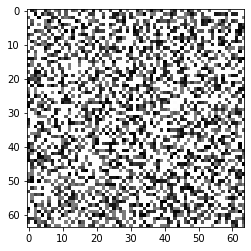

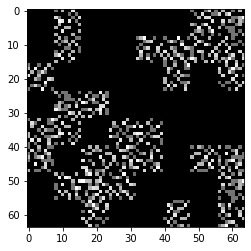

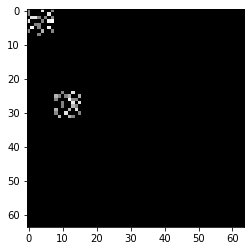

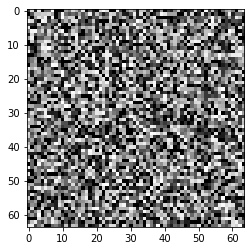

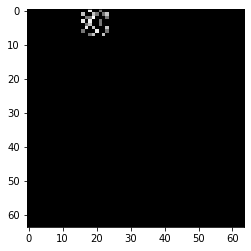

In [6]:
for i in range(0, 5):
    plt.imshow(train[i], cmap = 'gray')
    plt.show()

In [ ]:
print(f'Number of training images: {train.shape[0]}\nNumber of testing images {test.shape[0]}\n')
print(f'Number of training attack: {train_attack.shape[0]}\nNumber of vert flip train attack: {vert_flip_train_attack.shape[0]}\nNumber of training normal: {train_normal.shape[0]}\nNumber of vert flip training normal: {vert_flip_train_normal.shape[0]}\n')

print(f'Number of testing attack: {test_attack.shape[0]}\nNumber of vert flip test attack: {vert_flip_test_attack.shape[0]}\nNumber of hor flip test attack: {hor_flip_test_attack.shape[0]}\nNumber of test normal: {test_normal.shape[0]}\nNumber of vert flip test normal: {vert_flip_test_normal.shape[0]}\n' +
    f'Number of hor flip test normal: {hor_flip_test_normal.shape[0]}\nNumber of rotate90 left test normal: {rotate90l_test_normal.shape[0]}\nNumber of rotate90 right test normal: {rotate90r_test_normal.shape[0]}')

In [7]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [6]:
## create the training and testing data labels
## run this cell if using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [20]:
## create the training and testing data labels
## run this cell if using augmented data but not with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0]):
    training_labels.append('attack')
a
## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_train_normal.shape[0] + rotate90r_train_normal.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_train_normal.shape[0] + rotate90r_train_normal.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [8]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(      attack  normal
 0          1       0
 1          1       0
 2          1       0
 3          1       0
 4          1       0
 ...      ...     ...
 3696       0       1
 3697       0       1
 3698       0       1
 3699       0       1
 3700       0       1
 
 [3701 rows x 2 columns],
      attack  normal
 0         1       0
 1         1       0
 2         1       0
 3         1       0
 4         1       0
 ..      ...     ...
 407       0       1
 408       0       1
 409       0       1
 410       0       1
 411       0       1
 
 [412 rows x 2 columns])

In [9]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 7)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 7)

In [10]:
KERNEL_SIZE = [2,2]
IMAGE_SIZE = [64,64,1]

cnn = Sequential()

## convolution 1
cnn.add(Conv2D(2**4, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Conv2D(2**5, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 3
cnn.add(Conv2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 4
cnn.add(Conv2D(2**7, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Conv2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

# ## convolution 6
# cnn.add(Conv2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(64, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_555x.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         32896     
__________

In [11]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 128, epochs = 250) ## smaller batch 128-256, 200-250 epochs
end = time.time()

os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/250
3701/3701 [==============================] - 6s 2ms/step - loss: 4.4094 - acc: 0.6083
Epoch 2/250
3701/3701 [==============================] - 2s 447us/step - loss: 2.5124 - acc: 0.6355
Epoch 3/250
3701/3701 [==============================] - 2s 449us/step - loss: 0.6948 - acc: 0.6452
Epoch 4/250
3701/3701 [==============================] - 2s 454us/step - loss: 0.6036 - acc: 0.6677
Epoch 5/250
3701/3701 [==============================] - 2s 454us/step - loss: 0.5851 - acc: 0.6885
Epoch 6/250
3701/3701 [==============================] - 2s 449us/step - loss: 0.5650 - acc: 0.7091
Epoch 7/250
3701/3701 [==============================] - 2s 452us/step - loss: 0.5367 - acc: 0.7375
Epoch 8/250
3701/3701 [==============================] - 2s 454us/step - loss: 0.5017 - acc: 0.7671
Epoch 9/250
3701/3701 [==============================] - 2s 448us/step - loss: 0.4608 - acc: 0.7984
Epoch 10/250
3701/3701 [==============================] - 2s 452us/step - loss: 0.4201 - acc: 0.8210
E

dict_keys(['loss', 'acc'])


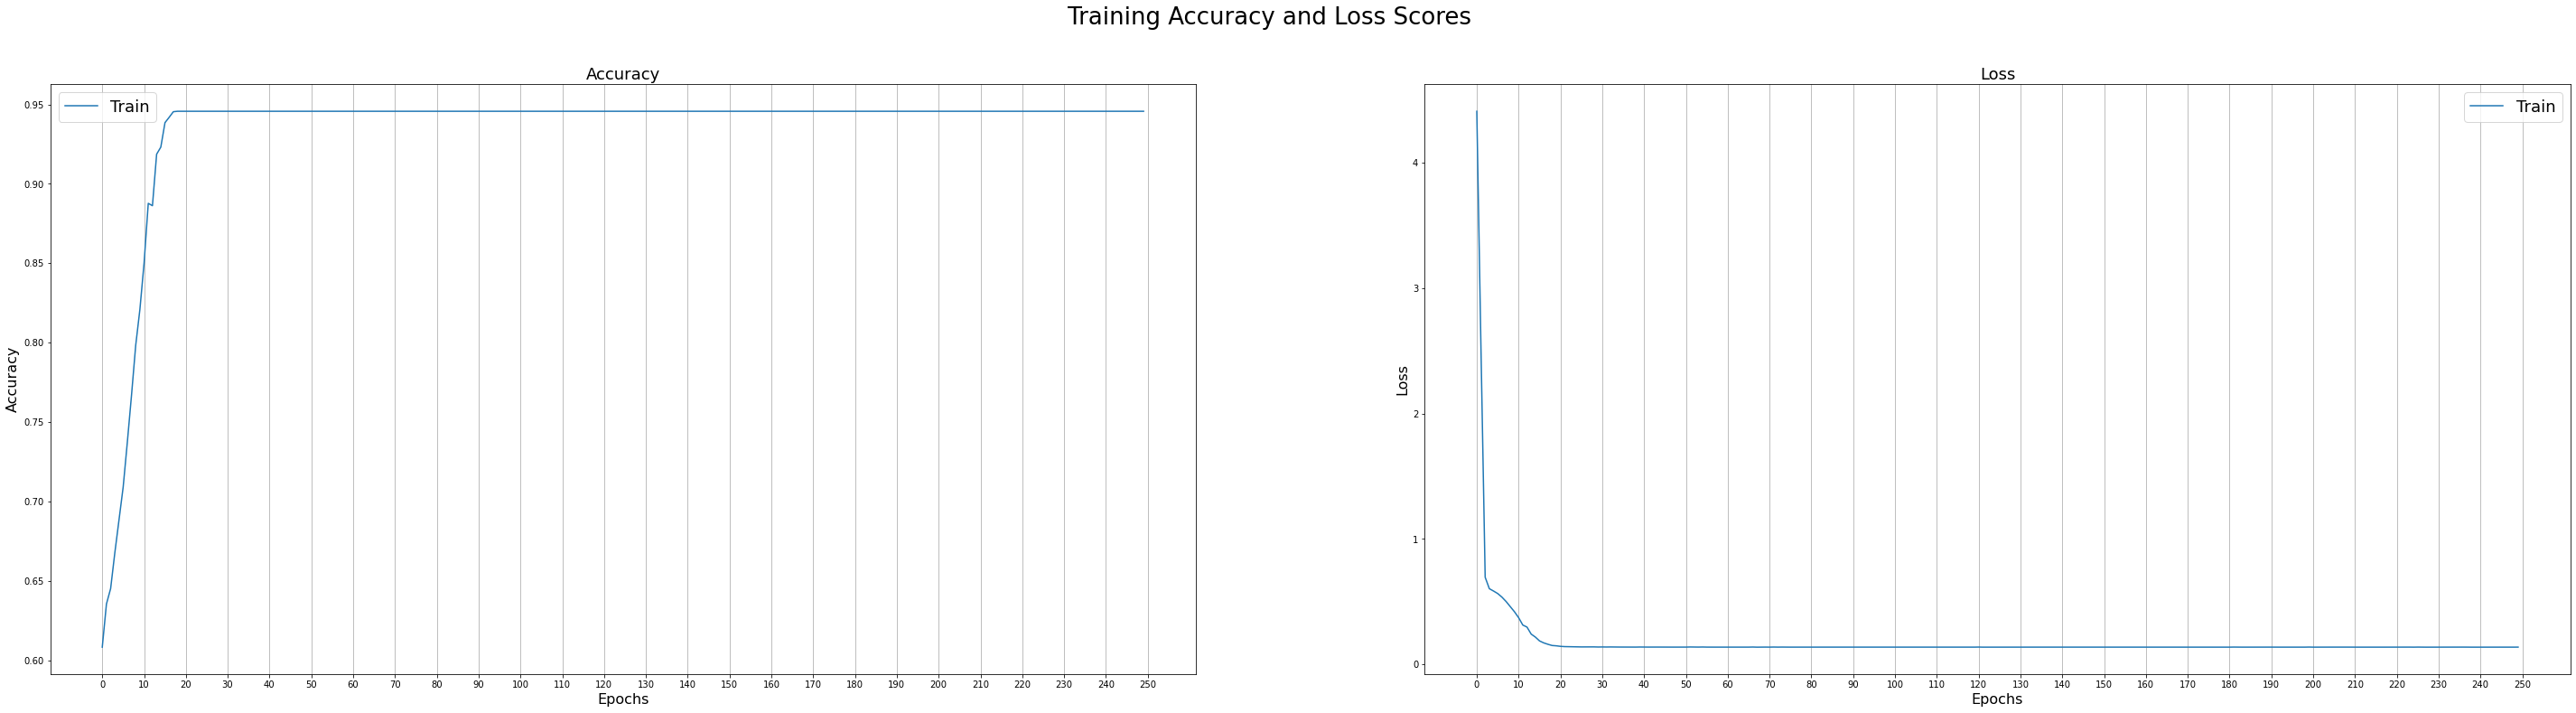

In [12]:
print(model_history.history.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 26)

axes[0].plot(model_history.history['acc'])
# axes[0].plot(model_history.history['val_acc'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 260, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
# axes[1].plot(model_history.history['val_loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 260, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [13]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 128, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 2.992	Accuracy = 62.99%


In [60]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

print('\t Attack\t Normal')
preds[:20]*100

	 Attack	 Normal


array([[ 99.99998,   0.00001],
       [  0.00474,  99.99032],
       [ 99.99941,   0.00001],
       [100.     ,   0.     ],
       [100.     ,   0.     ],
       [  0.     , 100.     ],
       [ 20.73767,  79.41474],
       [ 20.73767,  79.41474],
       [ 20.73767,  79.41474],
       [100.     ,   0.     ],
       [  0.8448 ,  98.8031 ],
       [  8.81538,  81.26327],
       [  0.17258,  99.93524],
       [ 99.47273,   1.45784],
       [  0.3227 ,  98.57411],
       [100.     ,   0.     ],
       [  0.05658,  99.77657],
       [ 99.8027 ,   0.03024],
       [ 18.67053,  60.39744],
       [  7.2627 ,  67.75021]], dtype=float32)

In [61]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Conv2D(2**4, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Conv2D(2**5, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Conv2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Conv2D(2**7, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))
    
    ## convolution 4
#     cnn.add(Conv2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
#     cnn.add(MaxPooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
#     cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(128, activation='relu'))
#     cnn.add(Dense(128, activation='relu'))
#     cnn.add(Dense(64, activation='relu'))
#     cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 128, epochs = 200)

In [63]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation: \n{round(score.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{score}')

os.system('say "cross validation finished"')

Epoch 1/200
329/329 [==============================] - 7s 21ms/step - loss: 3.8590 - acc: 0.5137
Epoch 2/200
329/329 [==============================] - 0s 483us/step - loss: 6.2105 - acc: 0.5167
Epoch 3/200
329/329 [==============================] - 0s 482us/step - loss: 6.2141 - acc: 0.5912
Epoch 4/200
329/329 [==============================] - 0s 483us/step - loss: 6.1334 - acc: 0.5973
Epoch 5/200
329/329 [==============================] - 0s 465us/step - loss: 6.0352 - acc: 0.5988
Epoch 6/200
329/329 [==============================] - 0s 508us/step - loss: 5.9808 - acc: 0.6033
Epoch 7/200
329/329 [==============================] - 0s 476us/step - loss: 5.8016 - acc: 0.6064
Epoch 8/200
329/329 [==============================] - 0s 473us/step - loss: 4.9069 - acc: 0.6748
Epoch 9/200
329/329 [==============================] - 0s 474us/step - loss: 4.9463 - acc: 0.6748
Epoch 10/200
329/329 [==============================] - 0s 475us/step - loss: 4.8982 - acc: 0.6748
Epoch 11/200
329/329

0